In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score


In [13]:
!

datalab  drive


# Data exploration and preprocessnig

In [0]:
train_df = pd.read_csv("./drive/app/new_train.csv")

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 11 columns):
id                    29999 non-null object
vendor_id             29999 non-null int64
pickup_datetime       29999 non-null object
dropoff_datetime      29999 non-null object
passenger_count       29999 non-null int64
pickup_longitude      29999 non-null float64
pickup_latitude       29999 non-null float64
dropoff_longitude     29999 non-null float64
dropoff_latitude      29999 non-null float64
store_and_fwd_flag    29999 non-null object
trip_duration         29999 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 2.5+ MB


Define two functions for later use.


In [0]:
def euklidian_dist(a_x,a_y,b_x,b_y):
    return np.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)

def manhattan_dist(a_x,a_y,b_x,b_y):
    return np.absolute(a_x - b_x) + np.absolute(a_y - b_y)

Here we define our custom fields:
    1. Transform field pickup_datetime to extract information about: month, day of the month, day of the week 
        and hour.
        
    2. Euklidian distance between pickup place and dropoff place.
    
    3. Mahattan distance between pickup place and dropoff place, because we operate in NYC.
    
    4. We also transform trip_duration field with log function.

In [0]:
train_df['datetime'] = pd.to_datetime(train_df.pickup_datetime)
train_df['day_of_week'] = train_df.datetime.dt.dayofweek
train_df['hour'] = train_df.datetime.dt.hour
train_df['day_of_month'] = train_df.datetime.dt.day
train_df['month'] = train_df.datetime.dt.month
train_df['euklidian_distance'] = euklidian_dist(train_df.dropoff_latitude,  train_df.dropoff_longitude, train_df.pickup_latitude,train_df.pickup_longitude)
train_df['manhattan_distance'] = manhattan_dist(train_df.dropoff_latitude,  train_df.dropoff_longitude, train_df.pickup_latitude,train_df.pickup_longitude)
train_df['log_trip_duration'] = np.log(train_df.trip_duration)

In [0]:
#actual data frame
#train_df[:11]

We tranform use log function on trip_duration, because it is supposed reduce skeewnes.

More on that here
https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc

All I know is that can help with regression in some cases, and it was true in ours.

Here is what is correlation between given fields and a trip_duration, it gives us information how each field influences the output:


In [23]:
corr = train_df.corr()
print(corr["trip_duration"].sort_values(ascending = False))

trip_duration         1.000000
log_trip_duration     0.392120
euklidian_distance    0.165818
manhattan_distance    0.163206
pickup_longitude      0.073171
dropoff_longitude     0.056782
vendor_id             0.031772
month                 0.024332
passenger_count       0.017653
day_of_week           0.002711
hour                 -0.003013
day_of_month         -0.006444
dropoff_latitude     -0.039451
pickup_latitude      -0.051068
Name: trip_duration, dtype: float64


And here is correlation betwen given fields and log_trip_duration:


In [24]:
print(corr["log_trip_duration"].sort_values(ascending = False))

log_trip_duration     1.000000
euklidian_distance    0.602460
manhattan_distance    0.592825
trip_duration         0.392120
pickup_longitude      0.182845
dropoff_longitude     0.141514
month                 0.047987
hour                  0.043724
passenger_count       0.022469
vendor_id             0.011908
day_of_month          0.005124
day_of_week          -0.028068
dropoff_latitude     -0.130032
pickup_latitude      -0.159213
Name: log_trip_duration, dtype: float64


In [25]:
#column names
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'datetime', 'day_of_week', 'hour', 'day_of_month',
       'month', 'euklidian_distance', 'manhattan_distance',
       'log_trip_duration'],
      dtype='object')

We pick fields for later training.

In [0]:
#train_X = train_df[[ 'pickup_longitude', 'pickup_latitude',
#       'dropoff_longitude', 'dropoff_latitude',
 #        'month', 'day_of_week', 'hour',
  #      'euklidian_distance']].values



#names = [ 'pickup_longitude', 'pickup_latitude',
 #       'dropoff_longitude', 'dropoff_latitude',
  #       'month', 'day_of_week', 'hour',
   #     'euklidian_distance']
#print(names)


train_X = train_df[['vendor_id',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'day_of_week', 'hour', 'day_of_month',
       'month', 'euklidian_distance', 'manhattan_distance',
       ]].values


train_y = train_df['log_trip_duration'].values
#train_y_mean = np.mean(train_y)
#train_y = train_y / np.mean(train_y)
#print(train_y)

In [27]:
train_X

array([[ 2.00000000e+00,  1.00000000e+00, -7.39821548e+01, ...,
         3.00000000e+00,  1.76795395e-02,  1.98593139e-02],
       [ 1.00000000e+00,  1.00000000e+00, -7.39804153e+01, ...,
         6.00000000e+00,  2.04559040e-02,  2.64778138e-02],
       [ 2.00000000e+00,  1.00000000e+00, -7.39790268e+01, ...,
         1.00000000e+00,  5.99337994e-02,  8.01582337e-02],
       ...,
       [ 2.00000000e+00,  1.00000000e+00, -7.39838867e+01, ...,
         5.00000000e+00,  1.27606271e-02,  1.80206299e-02],
       [ 1.00000000e+00,  1.00000000e+00, -7.39948578e+01, ...,
         4.00000000e+00,  9.49074600e-03,  1.00097656e-02],
       [ 1.00000000e+00,  1.00000000e+00, -7.39489594e+01, ...,
         3.00000000e+00,  3.73405758e-02,  4.49790954e-02]])

We scale our input. By calculating mean of each column, and then dividing each element by mean of column it is in. After that operation all input fields should be moreover the same.

In [0]:
means = np.array([np.mean(train_X[:,i]) for i in range(len(train_X[0]))])
train_X = train_X / means

We now can check correlation betwen input fields. We visualize that with matrix.

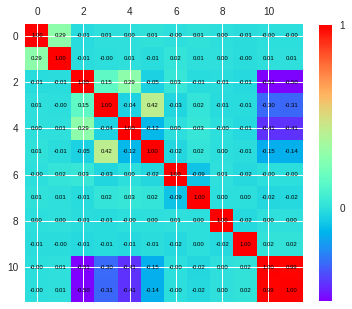

In [29]:
import matplotlib.pyplot as plt
cov_data = np.corrcoef(train_X.T)
img = plt.matshow(cov_data, cmap=plt.cm.rainbow)
plt.colorbar(img, ticks=[-1, 0, 1],fraction=0.045)
for x in range(cov_data.shape[0]):
    for y in range(cov_data.shape[1]):
        plt.text(x,y, "%0.2f" % cov_data[x,y], 
             size=6, color='black', ha="center", va="center")
plt.show()

In [0]:
#rows = 10000
#from sklearn.model_selection import train_test_split
#X, X_test,y, y_test = train_test_split(train_X[:rows], train_y[:rows], test_size=0.2)

# Model testing

1. Support vector machine with liear kernel

In [18]:
from sklearn.svm import SVR

model = SVR(kernel='linear',C=1)
score = cross_val_score(model, train_X[:100000], train_y[:100000], scoring='neg_mean_squared_error', cv=2)
print("average: {} std: {}".format(score.mean(), score.std()*2))

average: -0.3868881420623401 std: 0.005212292032081456


2.Svm with radian based function kernel

In [14]:
from sklearn.svm import SVR
model =  SVR(kernel='rbf', C=1)
score = cross_val_score(model, train_X[:100000], train_y[:100000], scoring='neg_mean_squared_error', cv=2)
print("average: {} std: {}".format(score.mean(), score.std()*2))



average: -0.5736572508309132 std: 0.01327097464046778


3.NN

In [0]:
#from keras.layers import Dense
#from keras.models import Sequential

#model = Sequential()
#model.add(Dense())

4.Random Forest regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=20, criterion='mae')
score = cross_val_score(model, train_X[:100000], train_y[:100000], scoring='neg_mean_squared_error', cv=2)
print("average: {} std: {}".format(score.mean(), score.std()*2))

average: -0.21345149229006122 std: 0.002447128431957629


In [15]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=20, criterion='mae',n_jobs=-1)
score = cross_val_score(model, train_X[:100000], train_y[:100000], scoring='neg_mean_squared_error', cv=2)
print("average: {} std: {}".format(score.mean(), score.std()*2))

average: -0.21553534933243257 std: 0.002423248989199267


In [0]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(criterion='mae')
score = cross_val_score(model, train_X[:100000], train_y[:100000], scoring='neg_mean_squared_error', cv=2)
print("average: {} std: {}".format(score.mean(), score.std()*2))

In [0]:
res = model.predict(train_X[:10])
for i, rec in enumerate(res):
    print("{} {}".format(rec, train_y[i]))